In [36]:
import apriltag
import cv2
import numpy as np
import copy
import matplotlib.pyplot as plt
import glob
from scipy.optimize import minimize, least_squares
from scipy.spatial.transform import Rotation as scipy_R

In [2]:
%matplotlib inline

# APRILTAG CORNER DEBUG IMAGE GENERATION

In [3]:
render_debug = True

detector = apriltag.Detector()

data_pair = ['0', '1']
data_pair = ['1', '2']
data_pair = ['2', '3']

camera_name_pair = ['cam%02d'%int(x) for x in data_pair]
data_root = '/workspace/multiview_calibration/MULTIVIEW/cal_image'
cam_dir = data_pair[0]+'-'+data_pair[1]
debug_dir = os.path.join(data_root, cam_dir, 'debug_cal')

if not os.path.exists(debug_dir):
    os.makedirs(debug_dir)

for cam_i in range(2):

    images = glob.glob(os.path.join(data_root, cam_dir, camera_name_pair[cam_i], '*.png'))
    images.sort()

    blue = [255,0,0]
    red = [0,0,255]
    greed = [0,255,0]
    purple = [255,0,255]
    colors = [blue, red, greed, purple]

    frame = 0
    #fname = images[0]
    for fname in images:
        
        img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
        img_plot = cv2.imread(fname)
        result = detector.detect(img)
        num_detection = len(result)

        for i_tag in range(num_detection):
        
            one_tag = result[i_tag]
            one_tagname = result[i_tag].tag_family
            one_corners = result[i_tag].corners

            if render_debug:
                for i_corner in range(4):
                    img_plot = cv2.circle(img_plot, (int(one_corners[i_corner,0]),int(one_corners[i_corner,1])), 0, colors[i_corner], 10)
        
        if render_debug:
            cv2.imwrite(os.path.join(debug_dir, camera_name_pair[cam_i]+'_%04d.png'%frame), img_plot)
            frame += 1
    

# APRILTAG IMAGE LOAD

In [4]:
img = cv2.imread('/workspace/multiview_calibration/ros-apriltag-board.png', cv2.IMREAD_GRAYSCALE)
img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
print(img.shape)
#april_sample.png
detector = apriltag.Detector()
base_result = detector.detect(img)

(2100, 2800)


In [5]:
blue = [255,0,0]
red = [0,0,255]
greed = [0,255,0]
purple = [255,0,255]

colors = [blue, red, greed, purple]
num_detection = len(base_result)

img_plot = cv2.imread('/workspace/multiview_calibration/ros-apriltag-board.png')
img_plot = cv2.rotate(img_plot, cv2.ROTATE_90_COUNTERCLOCKWISE)

for i_tag in range(num_detection):
    
    one_tag = base_result[i_tag]
    one_tagname = base_result[i_tag].tag_family
    one_corners = base_result[i_tag].corners
    
    for i_corner in range(4):
        img_plot = cv2.circle(img_plot, (int(one_corners[i_corner,0]),int(one_corners[i_corner,1])), 0, colors[i_corner], 30)

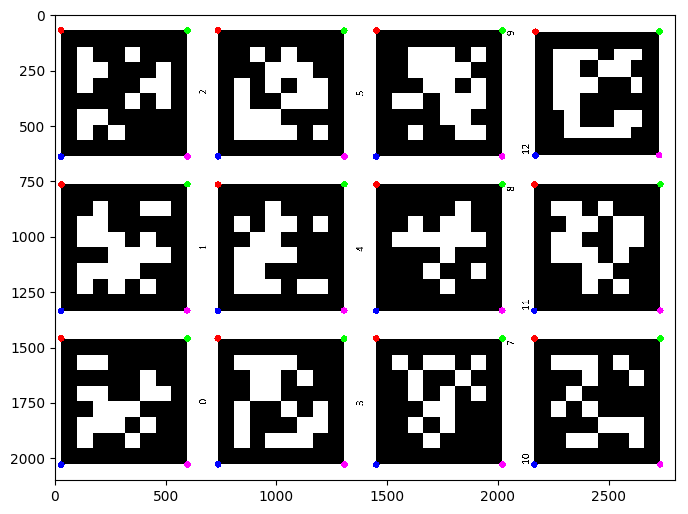

In [6]:
fig=plt.figure(figsize=(8,12), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(img_plot[:,:,::-1])

In [7]:
base_result[0].homography

array([[ 3.39252180e-12,  7.07104597e-01,  7.76696612e-01],
       [-7.07104597e-01, -3.34379516e-09,  4.33831660e+00],
       [ 8.13671510e-15, -1.91517933e-12,  2.48542916e-03]])

# CONVENTIONAL WAY TO CALIBRATE

In [8]:
# only two data pair available now.
data_pair = ['0', '1']

camera_name_pair = ['cam%02d'%int(x) for x in data_pair]
data_root = '/workspace/multiview_calibration/MULTIVIEW/cal_image'
cam_dir = data_pair[0]+'-'+data_pair[1]
debug_dir = os.path.join(data_root, cam_dir, 'debug_cal')

left_intrinsics = np.load(os.path.join(data_root, cam_dir, 'cam00_K.npy'))
right_intrinsics = np.load(os.path.join(data_root, cam_dir, 'cam01_K.npy'))

In [9]:
options = apriltag.DetectorOptions(families="tag36h11")
left_detector = apriltag.Detector(options)
right_detector = apriltag.Detector(options)

image_cal = '0000.png'

left_image_dir = os.path.join(data_root, cam_dir, camera_name_pair[0], image_cal)
right_image_dir = os.path.join(data_root, cam_dir, camera_name_pair[1], image_cal)

left_image = cv2.imread(left_image_dir, cv2.IMREAD_GRAYSCALE)
left_image_plot = cv2.imread(left_image_dir)
right_image = cv2.imread(right_image_dir, cv2.IMREAD_GRAYSCALE)
right_image_plot = cv2.imread(right_image_dir)

left_detector_result = left_detector.detect(left_image)
right_detector_result = right_detector.detect(right_image)
left_num_detection = len(left_detector_result)
right_num_detection = len(right_detector_result)

left_detected_tag = []
right_detected_tag = []

left_detected_2d = []
right_detected_2d = []

for i_tag in range(left_num_detection):
    one_tag = left_detector_result[i_tag]
    one_tagname = one_tag.tag_id
    one_corners = one_tag.corners
    left_detected_tag.append(one_tagname)
    left_detected_2d.append(one_corners)

for i_tag in range(right_num_detection):
    one_tag = right_detector_result[i_tag]
    one_tagname = one_tag.tag_id
    one_corners = one_tag.corners
    right_detected_tag.append(one_tagname)
    right_detected_2d.append(one_corners)

doubled_tag = list(set(left_detected_tag) & set(right_detected_tag))

apriltag_objp = []
for i_tag in range(len(doubled_tag)):
    base_one_tag = base_result[i_tag]
    base_one_corners = base_one_tag.corners
    apriltag_objp.append(base_one_corners)

apriltag_objp = np.array(apriltag_objp)
apriltag_objp = apriltag_objp.reshape(-1,2)
_zeros = np.zeros([apriltag_objp.shape[0],1])
apriltag_3d_objp = np.concatenate([apriltag_objp, _zeros], axis=1)
apriltag_3d_objp *= 50/(597.00000089 - 27.99999955) # synthesized 3D object points

left_detected_2d = np.array(left_detected_2d).reshape(-1, 2)
right_detected_2d = np.array(right_detected_2d).reshape(-1, 2)



In [11]:
# def camera projection function
def camera_projection(x):
    rotvec = x[0:3]
    transvec = x[3:6]
    rotmat = cv2.Rodrigues(rotvec)[0]
    camera_matrix = np.array([[rotmat[0,0], rotmat[0,1], rotmat[0,2], transvec[0]],
                              [rotmat[1,0], rotmat[1,1], rotmat[1,2], transvec[1]],
                              [rotmat[2,0], rotmat[2,1], rotmat[2,2], transvec[2]]])
    return camera_matrix

def project_3d_to_2d(camera_param_6d, obj_points_3d, intrinsic_matrix):
    image_points = cv2.projectPoints(obj_points_3d, camera_param_6d[:3], camera_param_6d[3:], intrinsic_matrix, None)
    return image_points


In [60]:
# optimize the camera parameters
# optimization parameters are rotvec 3, transvec 3.

# x6_left = np.array([-1.0, -1.0, .0, .0, .0, 1000.0])
# x6_right = np.array([.0, .0, .0, .0, .0, 1000.0])

x0 = np.array([.0, -np.pi, .0, .0, .0, 1000.0])

def loss(x, apriltag_3d_objp, intrinsic_matrix, detected_2d_points):
    # projected_2d_points = project_3d_to_2d(x, apriltag_3d_objp, intrinsic_matrix)[0].reshape(-1, 2) # (N, 2)
    projected_2d_points = cv2.projectPoints(apriltag_3d_objp, x[:3], x[3:], intrinsic_matrix, None)[0].reshape(-1, 2) # (N, 2)
    detected_2d_points = detected_2d_points.reshape(-1, 2)
    # rturn root mean square error
    return np.sqrt(np.mean((detected_2d_points - projected_2d_points)**2))

In [61]:
# res = minimize(loss, x0, args=(apriltag_3d_objp, left_intrinsics, left_detected_2d), method='nelder-mead',
#                options={'xatol': 1e-4, 'disp': True})

In [62]:
res = least_squares(loss, x0, jac_sparsity=None, verbose=0, x_scale='jac', ftol=1e-4, method='trf',
                    args=(apriltag_3d_objp, left_intrinsics, left_detected_2d))

In [63]:
print(loss(res.x, apriltag_3d_objp, left_intrinsics, left_detected_2d))
print(loss(x0, apriltag_3d_objp, left_intrinsics, left_detected_2d))

0.4915886677385723
316.0665781058329


In [57]:
res.x

array([ 1.38826027e+00,  8.52680732e-01, -2.88608231e+00, -8.91469379e+00,
       -1.84873972e+02,  1.11308595e+03])

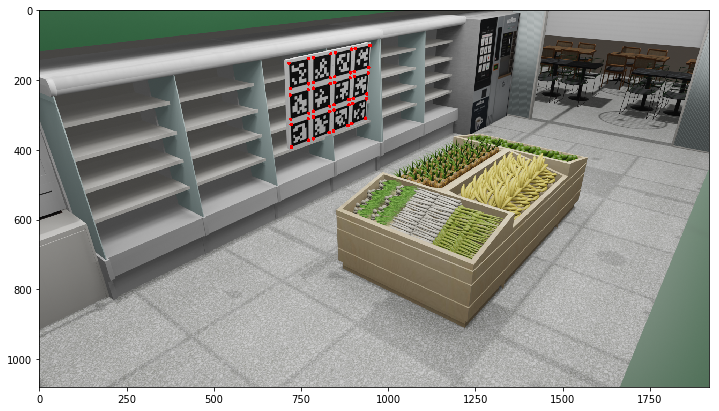

In [58]:
left_image_plot_copy = copy.deepcopy(left_image_plot)

# plot left_detected_2d points
for i in range(len(left_detected_2d)):
    cv2.circle(left_image_plot_copy, (int(left_detected_2d[i][0]), int(left_detected_2d[i][1])), 5, (0, 0, 255), -1)

figsize = (12, 8)
fig = plt.figure(figsize=figsize)
plt.imshow(left_image_plot_copy[:,:,::-1])

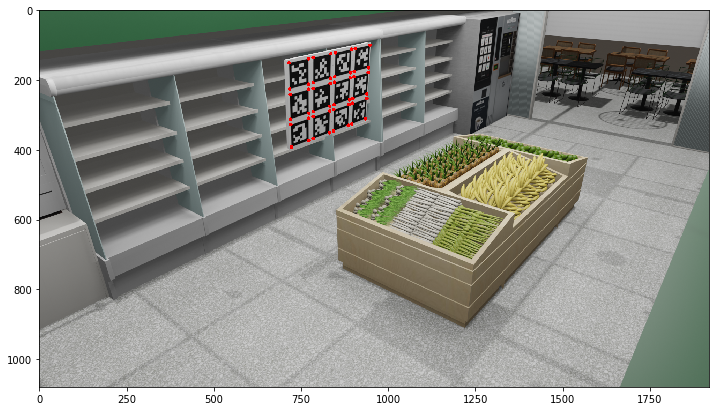

In [59]:
left_image_plot_copy = copy.deepcopy(left_image_plot)

# projected_2d_points = project_3d_to_2d(x, apriltag_3d_objp, intrinsic_matrix)[0].reshape(-1, 2) # (N, 2)
projected_2d_points = project_3d_to_2d(res.x, apriltag_3d_objp, left_intrinsics)[0].reshape(-1, 2)


# plot left_detected_2d points
for i in range(len(projected_2d_points)):
    cv2.circle(left_image_plot_copy, (int(projected_2d_points[i][0]), int(projected_2d_points[i][1])), 5, (0, 0, 255), -1)

figsize = (12, 8)
fig = plt.figure(figsize=figsize)
plt.imshow(left_image_plot_copy[:,:,::-1])

# SYNTHESIS

In [7]:
data_pair = ['0', '1']
data_pair = ['1', '2']
data_pair = ['2', '3']

camera_name_pair = ['cam%02d'%int(x) for x in data_pair]
data_root = '/workspace/multiview_calibration/MULTIVIEW/cal_image'
cam_dir = data_pair[0]+'-'+data_pair[1]
debug_dir = os.path.join(data_root, cam_dir, 'debug_cal')

for cam_i in range(2):
    detector = apriltag.Detector()

    # Arrays to store object points and image points from all the images.
    april_objpoints = [] # 3d point in real world space
    april_imgpoints = [] # 2d points in image plane.

    images = glob.glob(os.path.join(data_root, cam_dir, camera_name_pair[cam_i], '*.png'))
    # images = glob.glob(os.path.join(data_root, 'raw_data', '*.png'))
    images.sort()

    for fname in images:
        
        img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
        img_plot = cv2.imread(fname)
        result = detector.detect(img)
        num_detection = len(result)
        
        detected_tag = []
        april_imgpt = []
        for i_tag in range(num_detection):
            one_tag = result[i_tag]
            detected_tag.append(one_tag.tag_id)
            one_corners = one_tag.corners
            april_imgpt.append(one_corners)
            
        april_imgpt = np.array(april_imgpt)
        april_imgpt = april_imgpt.reshape(-1, 1, 2)
        april_imgpoints.append(april_imgpt.astype(np.float32))
        # MAKE OBJP
        apriltag_objp = []
        for i_tag in detected_tag:
            base_one_tag = base_result[i_tag]
            base_one_corners = base_one_tag.corners
            apriltag_objp.append(base_one_corners)

        apriltag_objp = np.array(apriltag_objp)
        apriltag_objp = apriltag_objp.reshape(-1,2)
        _zeros = np.zeros([apriltag_objp.shape[0],1])
        apriltag_objp = np.concatenate([apriltag_objp, _zeros], axis=1)
        apriltag_objp *= 50/(597.00000089 - 27.99999955)
        april_objpoints.append(apriltag_objp.astype(np.float32))

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(april_objpoints, april_imgpoints, img.shape[::-1],None,None)
    print(ret)
    print(mtx)
    assert ret < 0.9, 'reprojection error is too high!'
    # SAVE NUMPY K INTRINSIC FILE
    intrinsic_numpy_dir = os.path.join(data_root, cam_dir, camera_name_pair[cam_i]+'_K.npy')
    np.save(intrinsic_numpy_dir, mtx)
    rvec_numpy_dir = os.path.join(data_root, cam_dir, camera_name_pair[cam_i]+'_rvec.npy')
    np.save(rvec_numpy_dir, np.array(rvecs))
    tvec_numpy_dir = os.path.join(data_root, cam_dir, camera_name_pair[cam_i]+'_tvec.npy')
    np.save(tvec_numpy_dir, np.array(tvecs))

    # LATER, DISTORTION SHOULD BE CONSIDERED.


0.7865249093645192
[[1.38100747e+03 0.00000000e+00 9.05225055e+02]
 [0.00000000e+00 1.36361053e+03 5.58513087e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
0.8607206984375707
[[913.74629805   0.         960.42813562]
 [  0.         931.60856703 517.37598816]
 [  0.           0.           1.        ]]


# CALCULATE R and T

In [8]:
from scipy.spatial.transform import Rotation as scipy_R

In [9]:
data_pair = ['0', '1']
data_pair = ['1', '2']
data_pair = ['2', '3']

camera_name_pair = ['cam%02d'%int(x) for x in data_pair]
data_root = '/workspace/multiview_calibration/MULTIVIEW/cal_image'
cam_dir = data_pair[0]+'-'+data_pair[1]

first_K_np = np.load(os.path.join(data_root, cam_dir, camera_name_pair[0]+'_K.npy')) # 3, 3
second_K_np = np.load(os.path.join(data_root, cam_dir, camera_name_pair[1]+'_K.npy'))
first_rvec_np = np.load(os.path.join(data_root, cam_dir, camera_name_pair[0]+'_rvec.npy')) # 10, 3, 1
second_rvec_np = np.load(os.path.join(data_root, cam_dir, camera_name_pair[1]+'_rvec.npy'))
first_tvec_np = np.load(os.path.join(data_root, cam_dir, camera_name_pair[0]+'_tvec.npy'))
second_tvec_np = np.load(os.path.join(data_root, cam_dir, camera_name_pair[1]+'_tvec.npy'))

In [10]:
def calculate_Tr(K_np, rvec_np, tvec_np):
    _R_cv2bcam = np.array([[1,0,0],
                       [0,-1,0],
                       [0,0,-1]])
    R, _ = cv2.Rodrigues(rvec_np)
    # t = tvec_np[_i]/100. #(mm to M)? scale problem exist.
    t = tvec_np/100. #(mm to M)? scale problem exist.
    # k = first_K_np
    R_bcam= np.matmul(_R_cv2bcam, R)
    T_bcam = np.matmul(_R_cv2bcam, t)                       
    R_world = R_bcam.transpose()
    T_world = -np.matmul(R_world, T_bcam)

    R_world = R_world.reshape(3,3)
    T_world = T_world.reshape(3,1)

    Tr = np.identity(4)
    Tr[:3,:3] = R_world
    Tr[:3,3:] = T_world

    return Tr

In [11]:
# i = 0

# Tr_first = calculate_Tr(K_np=first_K_np, rvec_np=first_rvec_np[i], tvec_np=first_tvec_np[i])
# Tr_second = calculate_Tr(K_np=second_K_np, rvec_np=second_rvec_np[i], tvec_np=second_tvec_np[i])

# R_world_first = Tr_first[:3,:3]
# T_world_first = Tr_first[:3,3:]
# R_world_second = Tr_second[:3,:3]
# T_world_second = Tr_second[:3,3:]

# np.save(os.path.join(data_root, cam_dir, camera_name_pair[0]+'_Tr.npy'), Tr_first)
# np.save(os.path.join(data_root, cam_dir, camera_name_pair[1]+'_Tr.npy'), Tr_second)

In [12]:
trans_rvec_list = []
trans_tvec_list = []

for i in range(len(first_rvec_np)):

    # rvec and tvec to world space
    R_first, _ = cv2.Rodrigues(first_rvec_np[i])
    R_world_first = R_first.transpose()
    t_first = first_tvec_np[i]
    t_world_first = -np.matmul(R_world_first, t_first)

    R_second, _ = cv2.Rodrigues(second_rvec_np[i])
    R_world_second = R_second.transpose()
    t_second = second_tvec_np[i]
    t_world_second = -np.matmul(R_world_second, t_second)

    # Ttrans + t_first = t_second
    T_trans_world = t_world_second - t_world_first
    # R_first * Rtrans = R_second
    R_trans_world = np.matmul(np.linalg.inv(R_world_first), R_world_second)
    T_trans_world = np.matmul(np.linalg.inv(R_world_first), T_trans_world)

    # TO CAM COORD
    R_trans_cam = R_trans_world.transpose()
    T_trans_cam = -np.matmul(R_trans_cam, T_trans_world)

    r_scipy = scipy_R.from_matrix(R_trans_cam)
    rvec_trans = r_scipy.as_rotvec().reshape(3,1)

    trans_rvec_list.append(rvec_trans)
    trans_tvec_list.append(T_trans_cam)

trans_rvec_list = np.array(trans_rvec_list)
trans_tvec_list = np.array(trans_tvec_list)

In [13]:
np.save(os.path.join(data_root, cam_dir, camera_name_pair[0]+'_'+camera_name_pair[1]+'_trans_rvec.npy'), trans_rvec_list)
np.save(os.path.join(data_root, cam_dir, camera_name_pair[0]+'_'+camera_name_pair[1]+'_trans_tvec.npy'), trans_tvec_list)

In [14]:
Tr_origin = calculate_Tr(K_np=None, rvec_np=np.array([.0,.0,.0]), tvec_np=np.array([.0,.0,.0])) 
Tr_trans = calculate_Tr(K_np=None, rvec_np=trans_rvec_list[i], tvec_np=trans_tvec_list[i])
np.save(os.path.join(data_root, cam_dir, 'origin_Tr.npy'), Tr_origin)
np.save(os.path.join(data_root, cam_dir, camera_name_pair[0] +'_'+camera_name_pair[1]+'_Tr.npy'), Tr_trans)

# CHAIN RT

In [25]:
data_root = '/workspace/multiview_calibration/MULTIVIEW/cal_image'

data_pair = ['0', '1']
camera_name_pair = ['cam%02d'%int(x) for x in data_pair]
cam_dir = data_pair[0]+'-'+data_pair[1]
trans_rvec_1_2 = np.load(os.path.join(data_root, cam_dir, camera_name_pair[0]+'_'+camera_name_pair[1]+'_trans_rvec.npy')) # 3, 3
trans_rvec_0_1 = trans_rvec_0_1[0]
trans_tvec_0_1 = np.load(os.path.join(data_root, cam_dir, camera_name_pair[0]+'_'+camera_name_pair[1]+'_trans_tvec.npy')) # 3, 3
trans_tvec_0_1 = trans_tvec_0_1[0]

data_pair = ['1', '2']
camera_name_pair = ['cam%02d'%int(x) for x in data_pair]
cam_dir = data_pair[0]+'-'+data_pair[1]
trans_rvec_1_2 = np.load(os.path.join(data_root, cam_dir, camera_name_pair[0]+'_'+camera_name_pair[1]+'_trans_rvec.npy')) # 3, 3
trans_rvec_1_2 = trans_rvec_1_2[0]
trans_tvec_1_2 = np.load(os.path.join(data_root, cam_dir, camera_name_pair[0]+'_'+camera_name_pair[1]+'_trans_tvec.npy')) # 3, 3
trans_tvec_1_2 = trans_tvec_1_2[0]

data_pair = ['2', '3']
camera_name_pair = ['cam%02d'%int(x) for x in data_pair]
cam_dir = data_pair[0]+'-'+data_pair[1]
trans_rvec_2_3 = np.load(os.path.join(data_root, cam_dir, camera_name_pair[0]+'_'+camera_name_pair[1]+'_trans_rvec.npy')) # 3, 3
trans_rvec_2_3 = trans_rvec_2_3[0]
trans_tvec_2_3 = np.load(os.path.join(data_root, cam_dir, camera_name_pair[0]+'_'+camera_name_pair[1]+'_trans_tvec.npy')) # 3, 3
trans_tvec_2_3 = trans_tvec_2_3[0]

In [41]:
def get_RT_world_from_rtvec(_rvec=[.0,.0,.0], _tvec=[.0,.0,.0]):
    _R_c, _ = cv2.Rodrigues(_rvec)
    _R_w = _R_c.transpose()
    _T_c = _tvec
    _T_w = -np.matmul(_R_w, _T_c)
    return _R_w, _T_w

In [51]:
def from_world_to_cam_coord(_R_w, _T_w):
    _R_cam = _R_w.transpose()
    _T_cam = -np.matmul(_R_cam, _T_w)
    _r_scipy = scipy_R.from_matrix(_R_cam)
    _rvec = _r_scipy.as_rotvec().reshape(3,1)
    _tvec = _T_cam.reshape(3,1)
    return _rvec, _tvec

In [63]:
# rvec and tvec to world space
R_world_0_1, T_world_0_1 = get_RT_world_from_rtvec(_rvec=trans_rvec_0_1, _tvec=trans_tvec_0_1)
R_world_1_2, T_world_1_2 = get_RT_world_from_rtvec(_rvec=trans_rvec_1_2, _tvec=trans_tvec_1_2)
R_world_2_3, T_world_2_3 = get_RT_world_from_rtvec(_rvec=trans_rvec_2_3, _tvec=trans_tvec_2_3)

In [64]:
# 0 - 1
rvec_0_1, tvec_0_1 = from_world_to_cam_coord(_R_w=R_world_0_1, _T_w=T_world_0_1)

# 0 - 2
R_world_0_2 = np.matmul(R_world_0_1, R_world_1_2)
T_world_0_2 = T_world_0_1 + np.matmul(R_world_0_1, T_world_1_2)
# TO CAM COORD
rvec_0_2, tvec_0_2 = from_world_to_cam_coord(_R_w=R_world_0_2, _T_w=T_world_0_2)

# 0 - 3
R_world_0_3 = np.matmul(R_world_0_2, R_world_2_3)
T_world_0_3 = T_world_0_2 + np.matmul(R_world_0_2, T_world_2_3)
# TO CAM COORD
rvec_0_3, tvec_0_3 = from_world_to_cam_coord(_R_w=R_world_0_3, _T_w=T_world_0_3)


In [65]:
Tr_origin = calculate_Tr(K_np=None, rvec_np=np.array([.0,.0,.0]), tvec_np=np.array([.0,.0,.0]))
np.save(os.path.join(data_root, 'origin_Tr.npy'), Tr_origin)

Tr_trans = calculate_Tr(K_np=None, rvec_np=rvec_0_1, tvec_np=tvec_0_1)
np.save(os.path.join(data_root, 'cam00_cam01'+'_Tr.npy'), Tr_trans)

Tr_trans = calculate_Tr(K_np=None, rvec_np=rvec_0_2, tvec_np=tvec_0_2)
np.save(os.path.join(data_root, 'cam00_cam02'+'_Tr.npy'), Tr_trans)

Tr_trans = calculate_Tr(K_np=None, rvec_np=rvec_0_3, tvec_np=tvec_0_3)
np.save(os.path.join(data_root, 'cam00_cam03'+'_Tr.npy'), Tr_trans)

'/workspace/multiview_calibration/MULTIVIEW/cal_image/2-3/cam00_cam02_Tr.npy'